In [ ]:
antGLasso.mat <- as.matrix(
    read.csv(
        "./localdata/antGLasso-improved-output.csv",
        header=FALSE,
        col.names=paste0("C", 1:565)
    )
)

In [ ]:
antGLasso.mat <- as.matrix(
    read.csv(
        "./localdata/antGLasso-output-raw.csv",
        header=FALSE,
        col.names=paste0("C", 1:565)
    )
)

In [ ]:
antGLasso.mat <- as.matrix(
    read.csv(
        "./localdata/antGLasso-output-raw-core.csv",
        header=FALSE,
        col.names=paste0("C", 1:565)
    )
)

In [1]:
antGLasso.mat <- as.matrix(
    read.csv(
        "./localdata/antGLasso-output-raw-eig-core.csv",
        header=FALSE,
        col.names=paste0("C", 1:565)
    )
)

In [ ]:
antGLasso.mat <- as.matrix( # poorly named
    read.csv(
        "./localdata/EiGLasso-output-raw.csv",
        header=FALSE,
        col.names=paste0("C", 1:565)
    )
)

In [ ]:
antGLasso.mat <- as.matrix( # poorly named
    read.csv(
        "./localdata/simple-ziln-estimator.csv",
        header=FALSE,
        col.names=paste0("C", 1:565)
    )
)

In [ ]:
antGLasso.mat <- as.matrix( # poorly named
    read.csv(
        "./localdata/TeraLasso-output-raw.csv",
        header=FALSE,
        col.names=paste0("C", 1:565)
    )
)

In [56]:
antGLasso.mat <- as.matrix( # poorly named
    read.csv(
        "./localdata/antGlasso-output-iter-raws.csv",
        header=FALSE,
        col.names=paste0("C", 1:565)
    )
)

In [66]:
antGLasso.mat <- as.matrix( # poorly named
    read.csv(
        "./localdata/antGlasso-output-iter-zs.csv",
        header=FALSE,
        col.names=paste0("C", 1:565)
    )
)

In [87]:
antGLasso.mat <- as.matrix( # poorly named
    read.csv(
        "./localdata/antGlasso-output-iter-raws--.csv",
        header=FALSE,
        col.names=paste0("C", 1:565)
    )
)

In [117]:
antGLasso.mat <- as.matrix( # poorly named
    read.csv(
        "./localdata/antGlasso-output-iter-zs--.csv",
        header=FALSE,
        col.names=paste0("C", 1:565)
    )
)

In [240]:
antGLasso.mat <- as.matrix( # poorly named
    read.csv(
        "./localdata/antGlasso-output-iter-raws--fast.csv",
        header=FALSE,
        col.names=paste0("C", 1:565)
    )
)

In [224]:
antGLasso.mat <- as.matrix( # poorly named
    read.csv(
        "./localdata/antGlasso-output-iter-zs--fast.csv",
        header=FALSE,
        col.names=paste0("C", 1:565)
    )
)

In [242]:
upper.bound <- 0.2
lower.bound <- 0.05
sum(abs(antGLasso.mat) > upper.bound) / 2
sum(abs(antGLasso.mat) > lower.bound) / 2

[1] 300.5

[1] 26888.5

In [243]:
lambdas.antGLasso <- exp(0:19 * (log(upper.bound) - log(lower.bound)) / 19 + log(lower.bound))

In [244]:
threshold.matrix <- function(mat., threshold) {
    mat <- matrix(0, dim(mat.)[[1]], dim(mat.)[[2]])
    mat[abs(mat.) < threshold] = 0
    mat[abs(mat.) > threshold] = 1
    diag(mat) <- 0
    return(mat)
}

In [245]:
antGLasso.path <- lapply(
    lambdas.antGLasso,
    function(thresh) threshold.matrix(antGLasso.mat, thresh)
)

In [246]:
library(igraph)
library(ggplot2)

In [247]:
get.assortativity.at.level <- function(adjacency.graph, taxmat, taxa.level) {
    groups <- as.integer(as.factor(taxmat[, taxa.level]))
    return(assortativity(adjacency.graph, groups))
}

get.assortativity.at.levels <- function(adjacency.graph, taxmat) {
    curried.assortativity <- function(taxa.level) get.assortativity.at.level(
        adjacency.graph,
        taxmat,
        taxa.level
    )
    return(
        lapply(
            colnames(taxmat),
            curried.assortativity
        )[2:length(colnames(taxmat))]
    )        
}

In [248]:
plot.all.assortativities <- function(path, taxmat, lambdas) {
    graphs <- lapply(
        lapply(path, graph.adjacency),
        as.undirected
    )
    assortativities <- lapply(
        graphs,
        function(graph) get.assortativity.at.levels(graph, taxmat)
    )

    # Remove first element as full of NaNs
    assortativities <- assortativities[2:length(assortativities)]
    lambdas.short <- lambdas[2:length(lambdas)]
    
    assortativities.1 <- as.numeric(lapply(assortativities, function(l) l[[1]]))
    assortativities.2 <- as.numeric(lapply(assortativities, function(l) l[[2]]))
    assortativities.3 <- as.numeric(lapply(assortativities, function(l) l[[3]]))
    assortativities.4 <- as.numeric(lapply(assortativities, function(l) l[[4]]))
    assortativities.5 <- as.numeric(lapply(assortativities, function(l) l[[5]]))
    ggplot(
        data.frame(assortativities.1),
        aes(x=lambdas.short)
    ) +
        geom_line(aes(y = assortativities.1, color = "Phylum")) +
        geom_line(aes(y = assortativities.2, color = "Class")) +
        geom_line(aes(y = assortativities.3, color = "Order")) +
        geom_line(aes(y = assortativities.4, color = "Family")) +
        geom_line(aes(y = assortativities.5, color = "Genus")) +
        scale_colour_manual("", 
            breaks = c("Phylum", "Class", "Order", "Family", "Genus"),
            values = c("black", "blue", "maroon", "red", "orange")
        ) +
        theme(legend.position = "top") +
        labs(x = "Regularization parameter lambda", y = "Assortativities") +
        ggtitle("Assortativities at different taxonomic levels")
}

In [249]:
# Load the data
load("localdata/ll_deep.rda")

# Rename the taxmat columns to something more informative
colnames(taxmat) <- c(
    "Domain",
    "Phylum",
    "Class",
    "Order",
    "Family",
    "Genus"
)

# Load the libraries
source("./localdata/Zi-LN-master/inference.R")
source("./localdata/Zi-LN-master/utils/utils.R")
library("huge")
library("igraph")

# Get a boolean 1135x3957 matrix of whether the species
# was found in the person or not
nonzeros <- counts > 0

# Get the number of distinct people that possessed each species
num.nonzeros <- apply(nonzeros, 2, sum)

# Get the total amount of people
total.cells <- dim(counts)[1]

# Only keep the species who appear in more than 20% of the people
keep.indices <- (num.nonzeros / total.cells) > 0.2
counts_el <- as.matrix(counts[, keep.indices])
write.csv(counts_el, "./localdata/filtered-raw-counts-ziln.csv")

taxmat_el <- taxmat[keep.indices,]

# Get the zs
options(warn = -1) # turn warnings off because otherwise it's gonna scream...
zs <- infer_Z(counts_el)

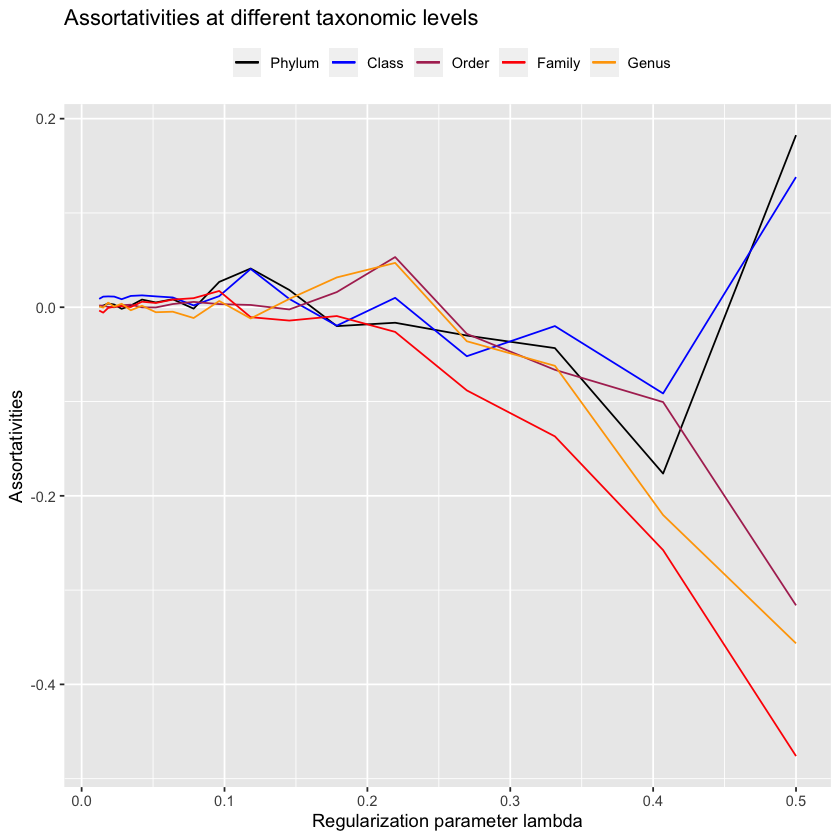

In [ ]:
# EiGLasso on transformed data (despite variable name)
plot.all.assortativities(antGLasso.path, taxmat_el, lambdas.antGLasso)

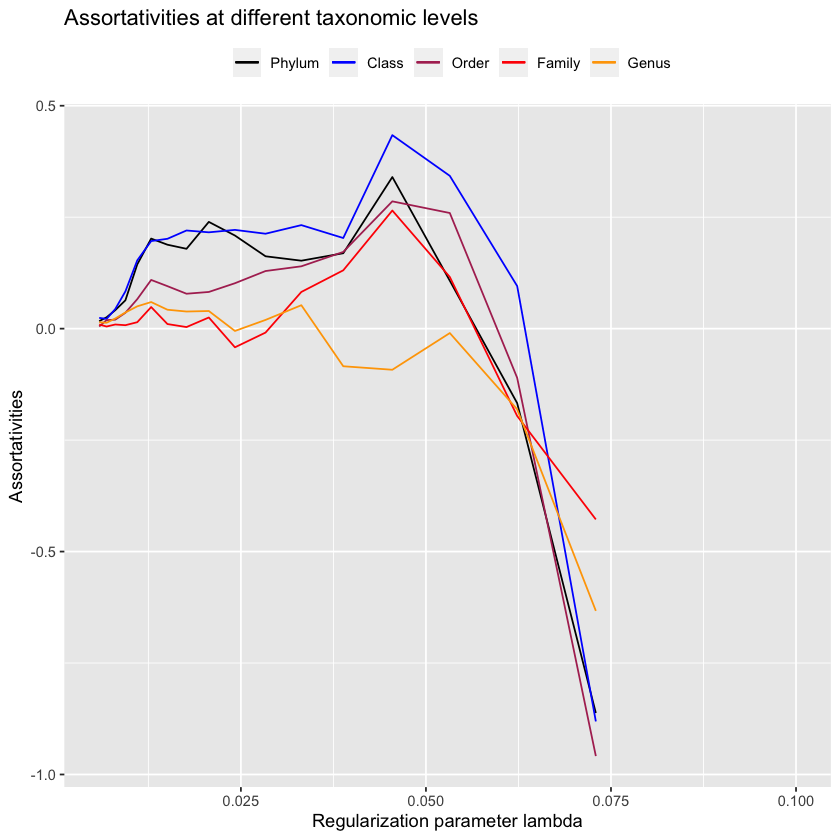

In [ ]:
# EiGLasso on raw data (despite variable name)
plot.all.assortativities(antGLasso.path, taxmat_el, lambdas.antGLasso)

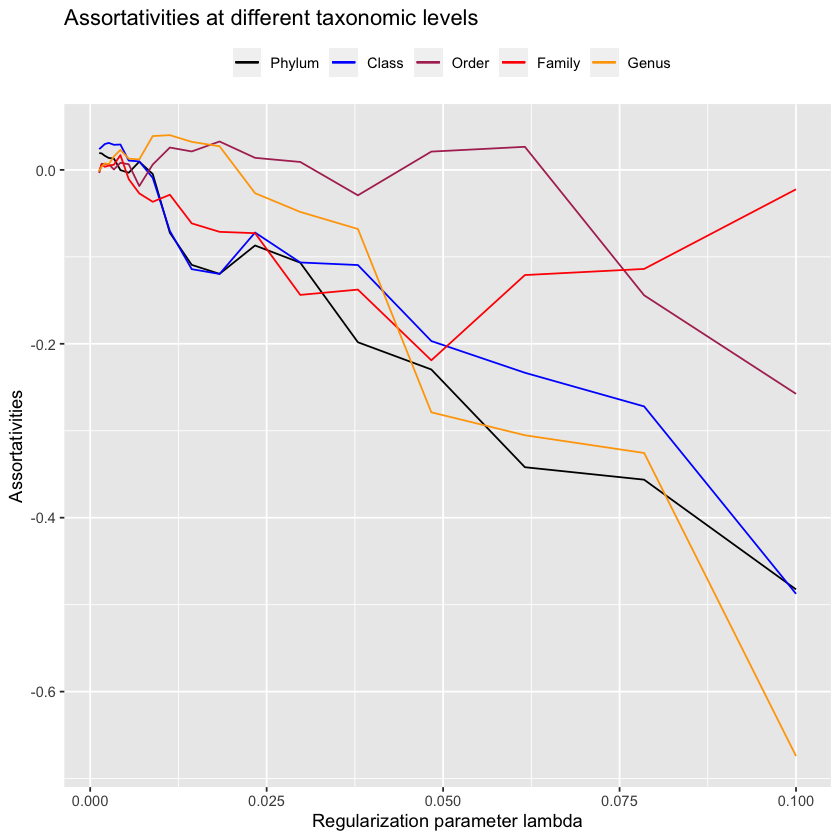

In [ ]:
# antGlasso on raw data
plot.all.assortativities(antGLasso.path, taxmat_el, lambdas.antGLasso)

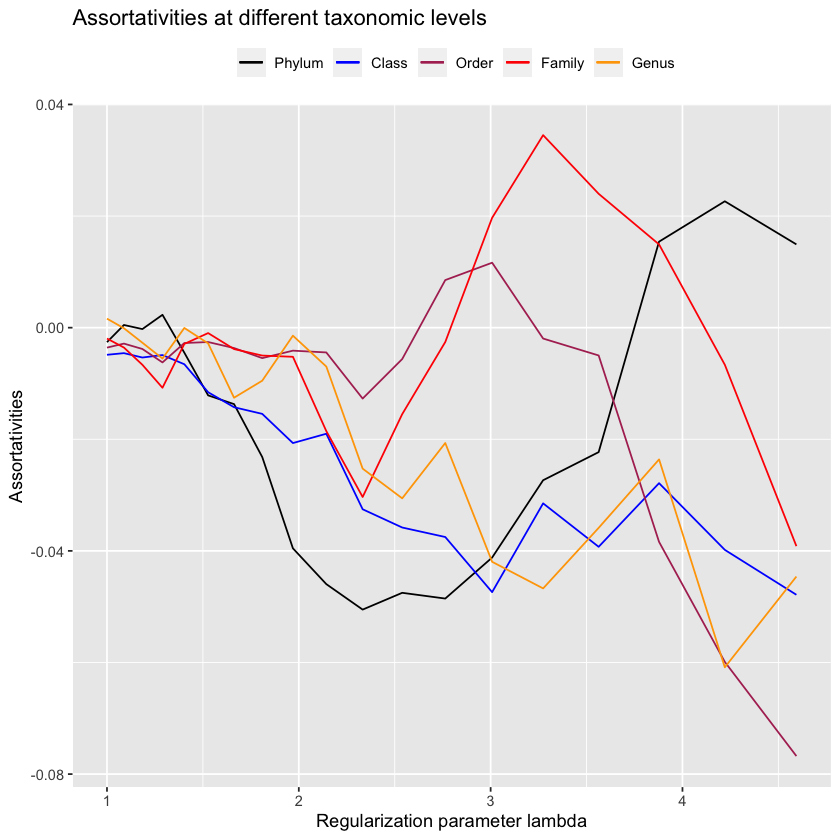

In [ ]:
# antGlasso with tera core on raw data
plot.all.assortativities(antGLasso.path, taxmat_el, lambdas.antGLasso)

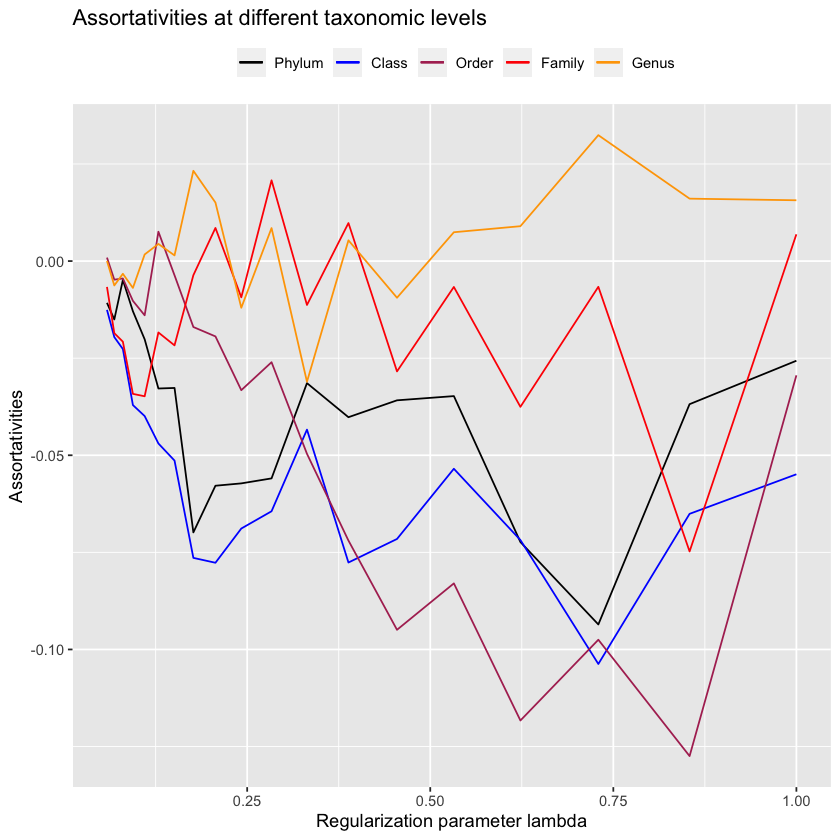

In [ ]:
# just the inversion of the empirical covariances
plot.all.assortativities(antGLasso.path, taxmat_el, lambdas.antGLasso)

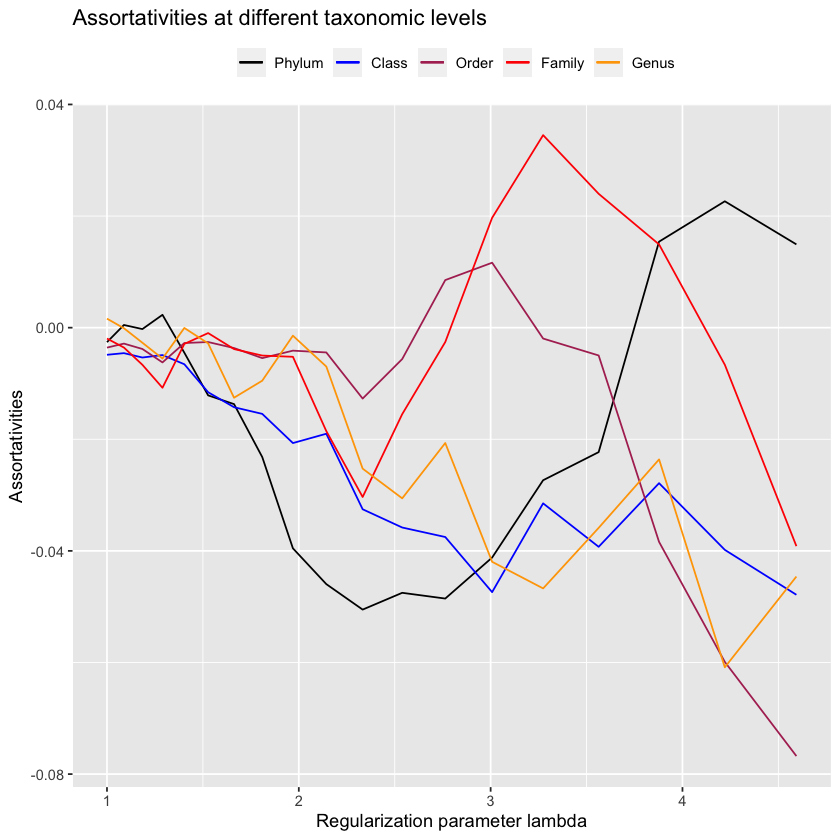

In [ ]:
# teralasso on raw data
plot.all.assortativities(antGLasso.path, taxmat_el, lambdas.antGLasso)

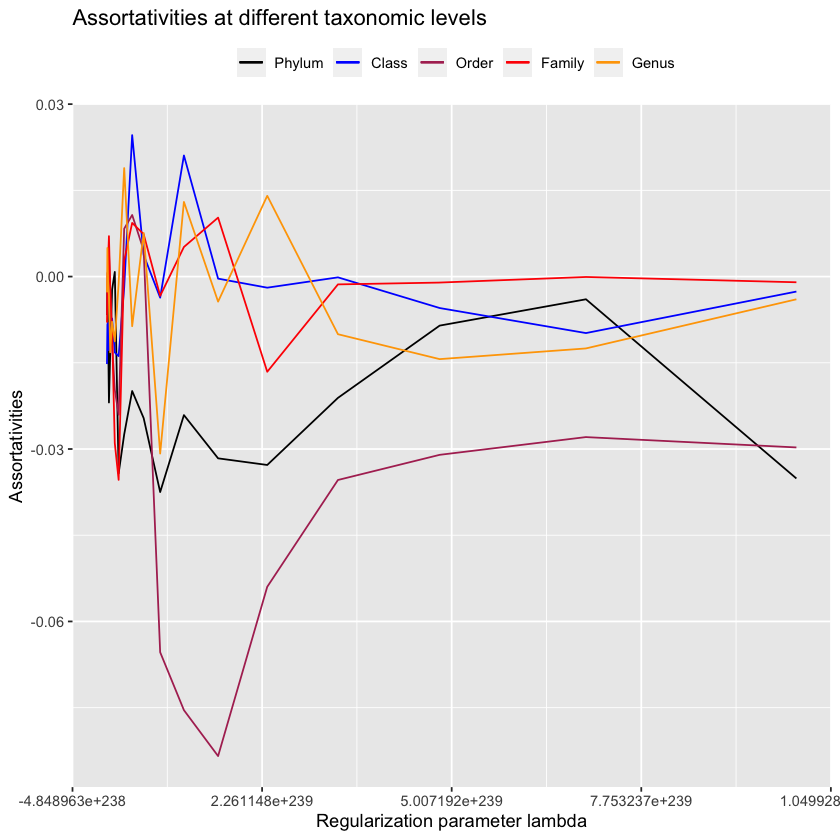

In [35]:
# antGLasso on raw data, eig core
plot.all.assortativities(antGLasso.path, taxmat_el, lambdas.antGLasso)

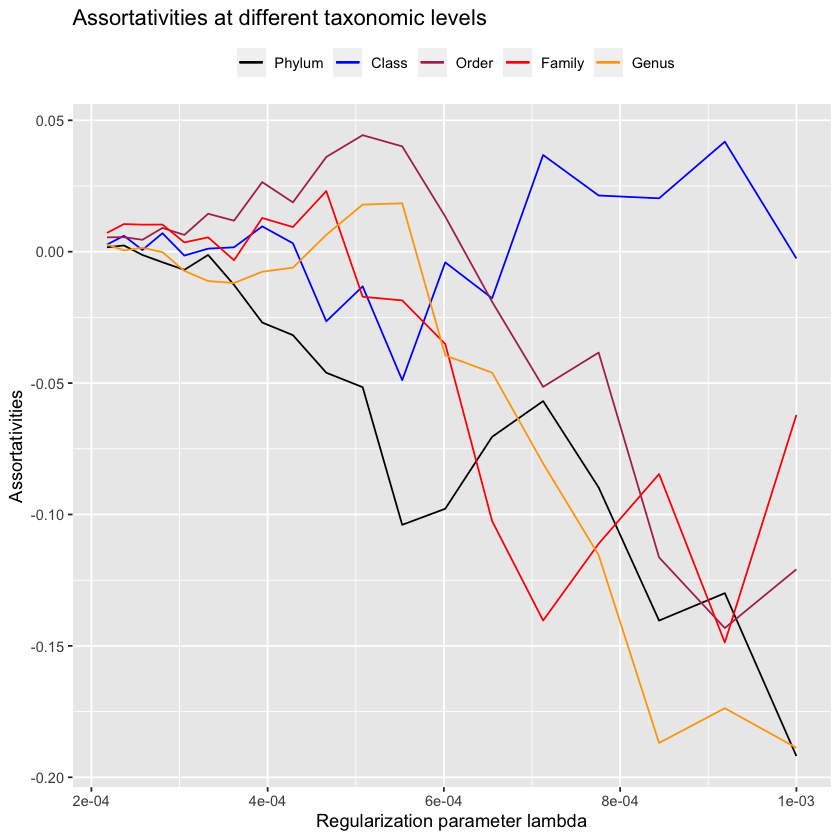

In [65]:
# antGLasso on raw data, iterative core
plot.all.assortativities(antGLasso.path, taxmat_el, lambdas.antGLasso)

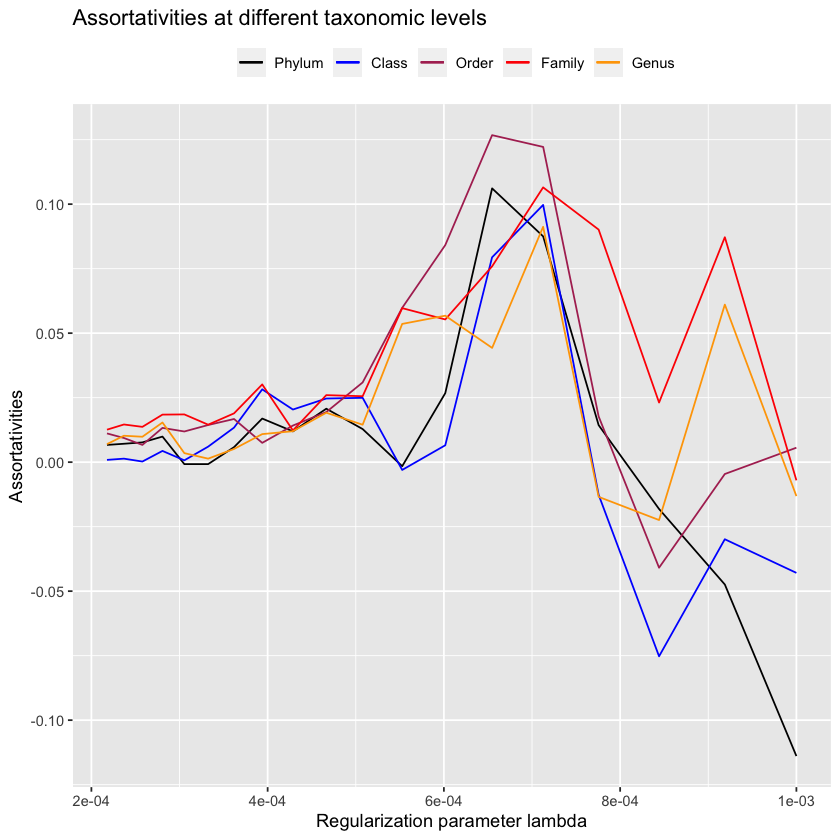

In [75]:
# antGLasso on zs raw data, iterative core
plot.all.assortativities(antGLasso.path, taxmat_el, lambdas.antGLasso)

In [86]:
lambdas.antGLasso[[15]]

[1] 0.0006547274

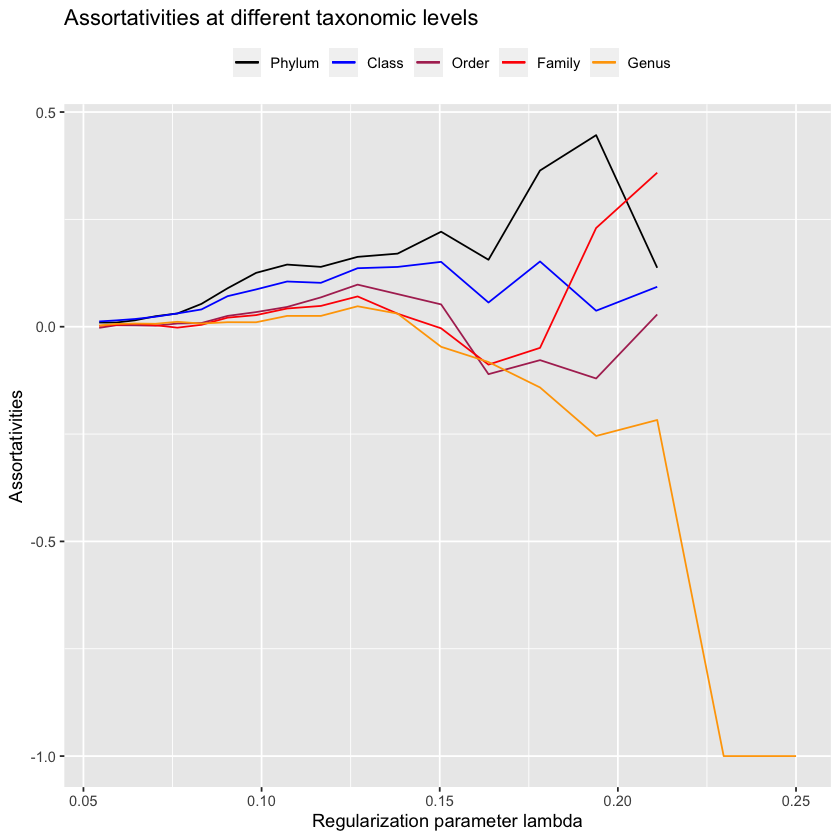

In [110]:
# antGLasso on zs raw data, iterative core fixed
plot.all.assortativities(antGLasso.path, taxmat_el, lambdas.antGLasso)

In [116]:
lambdas.antGLasso[[10]]

[1] 0.107167

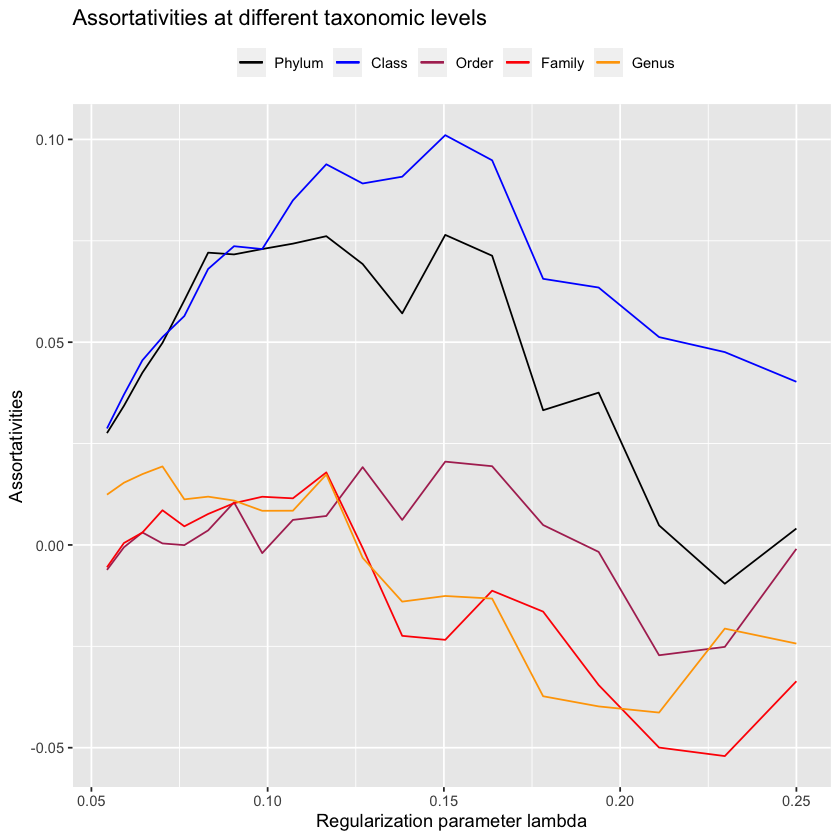

In [126]:
# antGLasso on zs data, iterative core fixed
plot.all.assortativities(antGLasso.path, taxmat_el, lambdas.antGLasso)

In [128]:
lambdas.antGLasso[[12]]

[1] 0.1269512

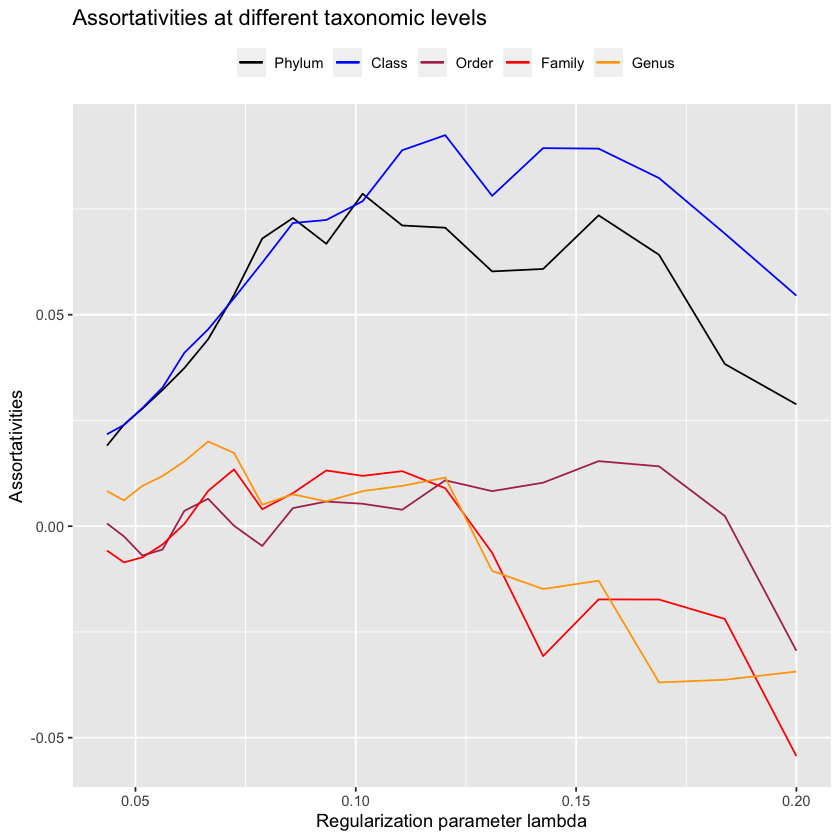

In [238]:
# antGLasso on zs data, iterative core fixed and sped up
plot.all.assortativities(antGLasso.path, taxmat_el, lambdas.antGLasso)

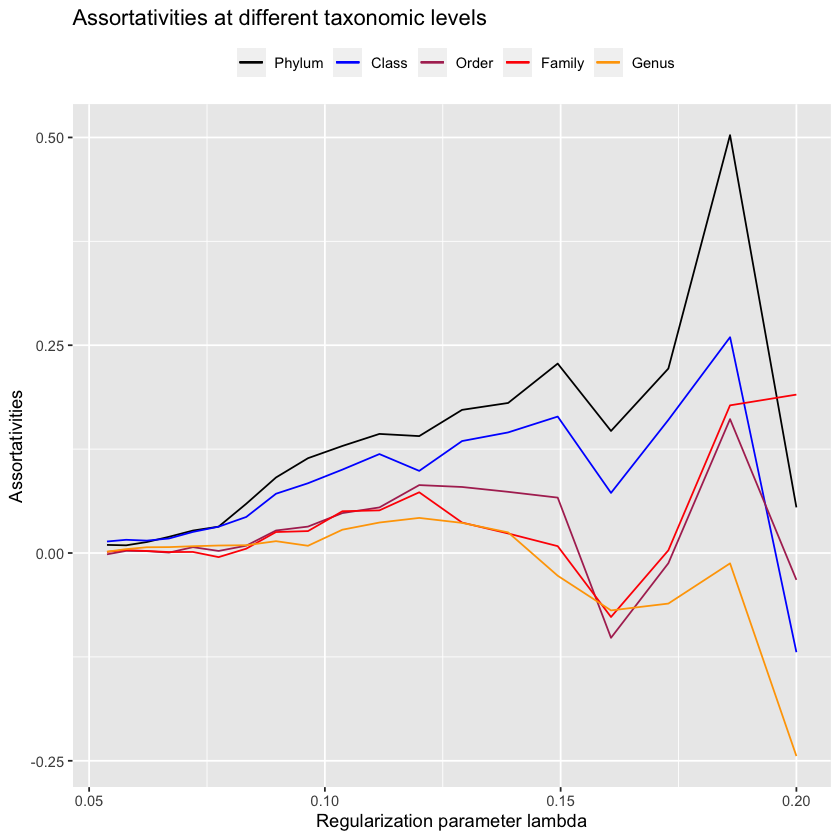

In [250]:
# antGLasso on raw data, iterative core fixed and sped up
plot.all.assortativities(antGLasso.path, taxmat_el, lambdas.antGLasso)

In [256]:
lambdas.antGLasso[[10]]

[1] 0.0964176

# Utilities

In [81]:
# Just to check that plotting still works
plot.graph <- function(adjacency.graph, taxmat_el, taxa.level) {
    color.graph.data <- color.graph(taxmat_el, taxa.level)
    taxmat.colors <- color.graph.data[[1]]
    unique.taxa <- color.graph.data[[2]]
    hex.map <- color.graph.data[[3]]
    plot(
        adjacency.graph,
        edge.color = "green",
        vertex.size = 5,
        vertex.label = "",
        vertex.color = taxmat.colors[,"color"],
        margin=c(0, 0, 0, 0)
    )
    plot(
        adjacency.graph,
        vertex.label.color = "#00000000",
        vertex.color = "#00000000",
        edge.color = "#00000000",
        vertex.frame.color = "#00000000"
    )
    legend('top',
           legend = unique.taxa,
           bg = "#757575",
           fill = hex.map,
           ncol = 2
    )
}

# Make a function to color the graph
color.graph <- function(taxmat_el, taxa.level) {
    # Add a "color" column to prepare for coloring graph nodes
    taxmat.colors <- cbind(taxmat_el, "#000000")
    colnames(taxmat.colors)[length(colnames(taxmat.colors))] <- "color"
    unique.taxa <- unique(taxmat.colors[,taxa.level])
    num.taxa <- length(unique.taxa)
    increment <- 89 / (num.taxa-1)
    increments <- 10 + round(increment * 0:(num.taxa-1))
    hex.map <- paste("#19", increments, "60", sep="")
    for (i in 1:num.taxa) {
        taxmat.colors[
            unique.taxa[i]==taxmat.colors[,taxa.level],
            "color"
        ] <- hex.map[i]
    }
    return(list(
        taxmat.colors,
        unique.taxa,
        hex.map
    ))
}

# Make Plot

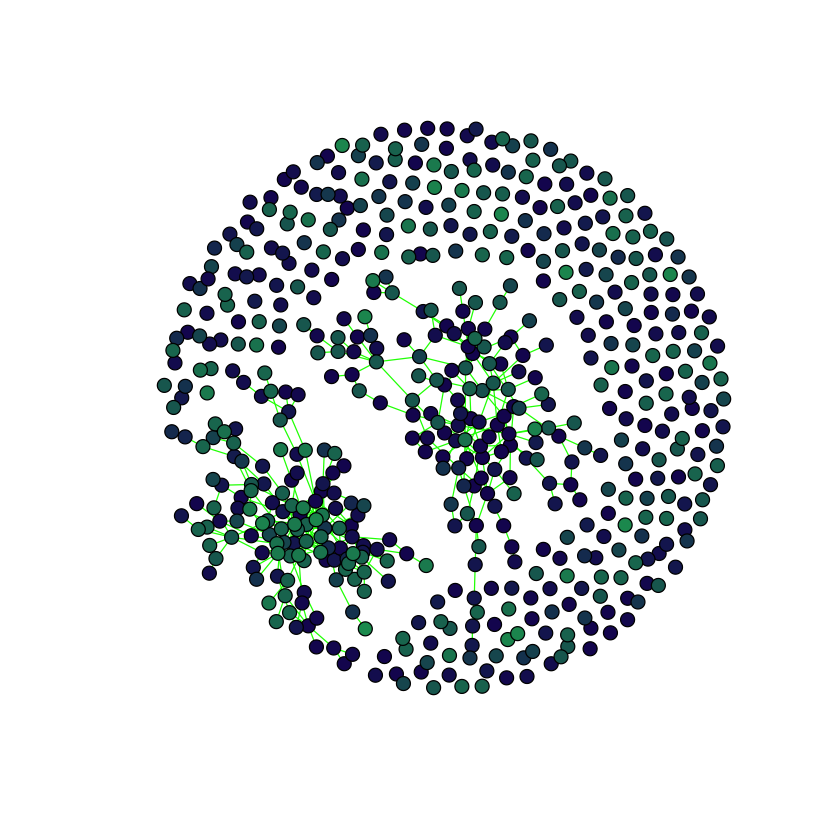

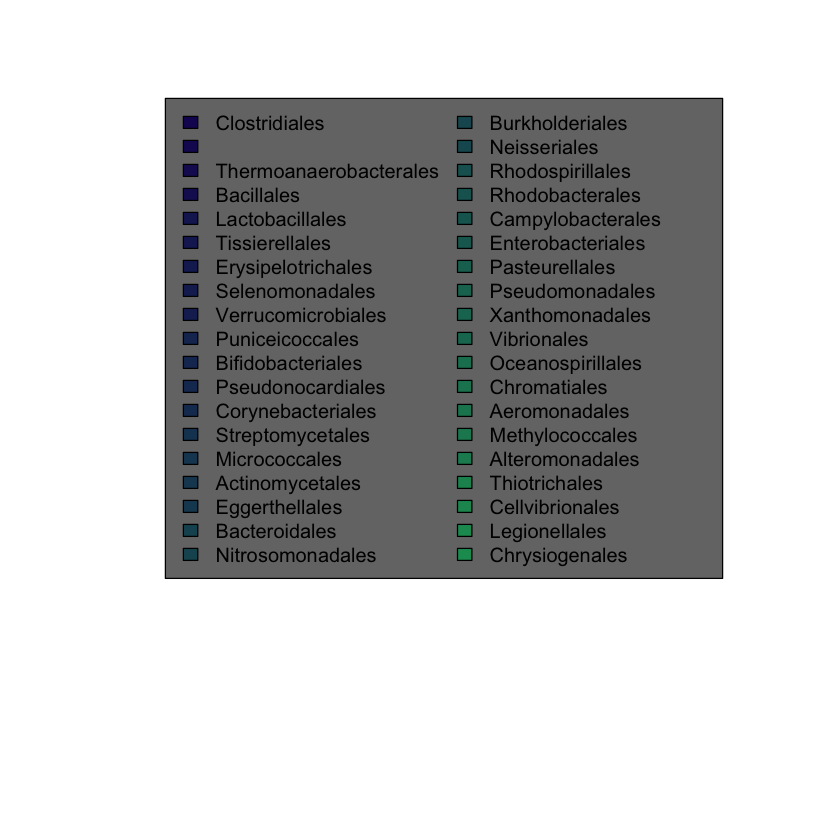

In [85]:
# antGLasso unfixed iterative core
plot.graph(
    graph.adjacency(
        antGLasso.path[[15]],
        mode = "Undirected"
    ),
    taxmat_el,
    "Order"
)

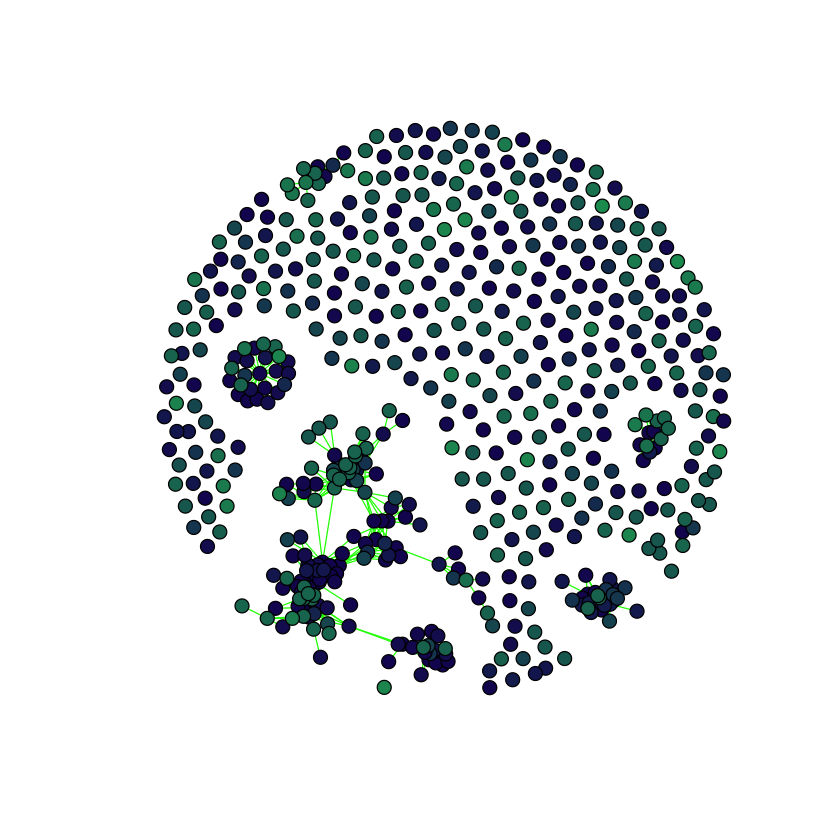

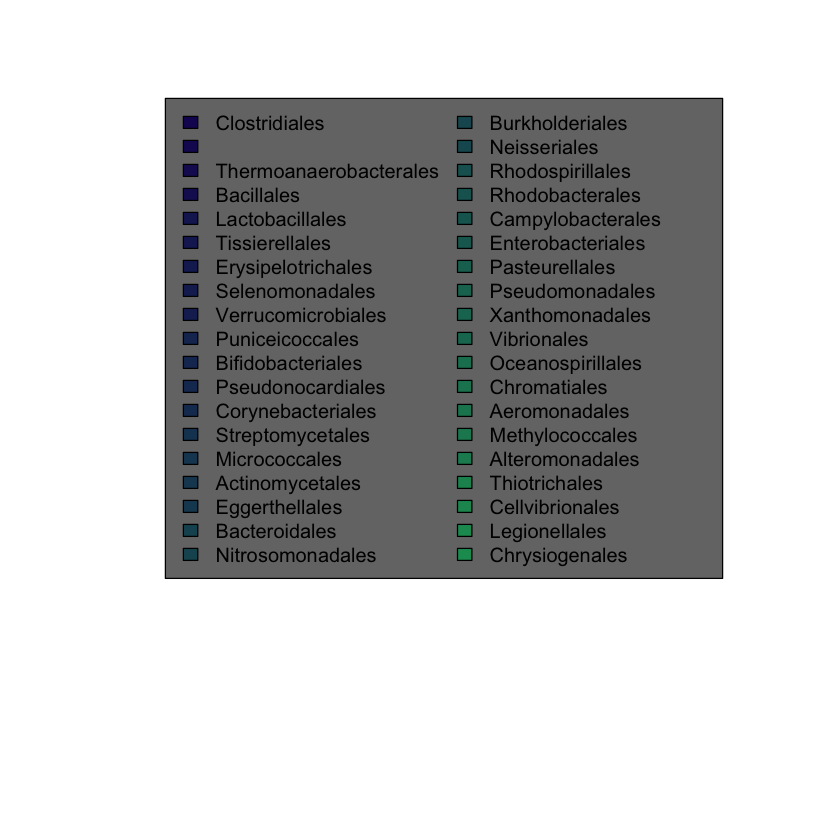

In [115]:
# antGLasso fixed iterative core
plot.graph(
    graph.adjacency(
        antGLasso.path[[10]],
        mode = "Undirected"
    ),
    taxmat_el,
    "Order"
)

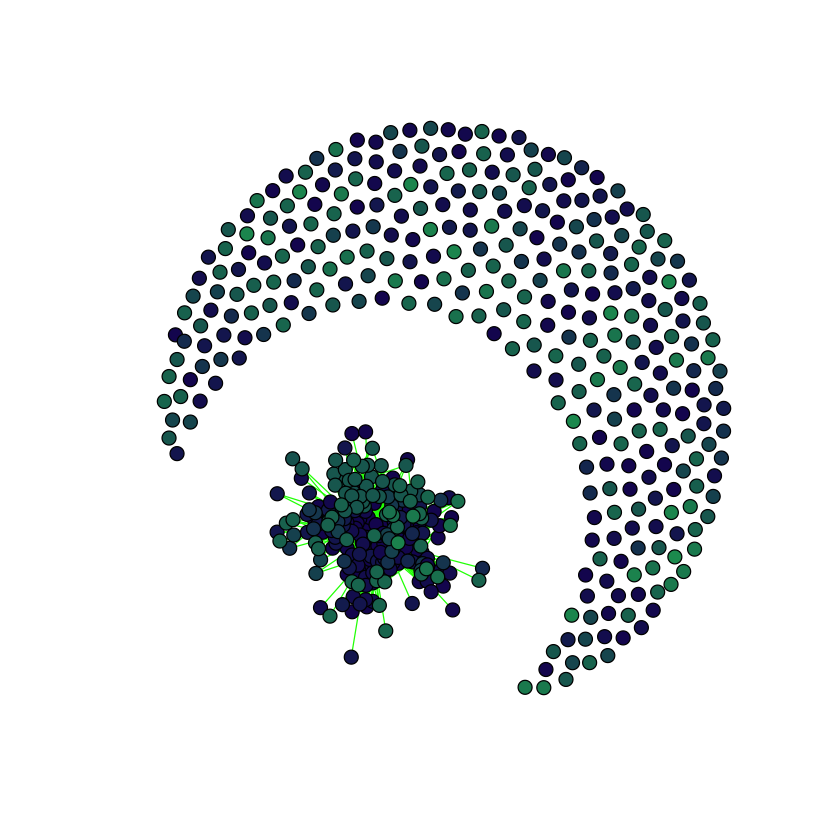

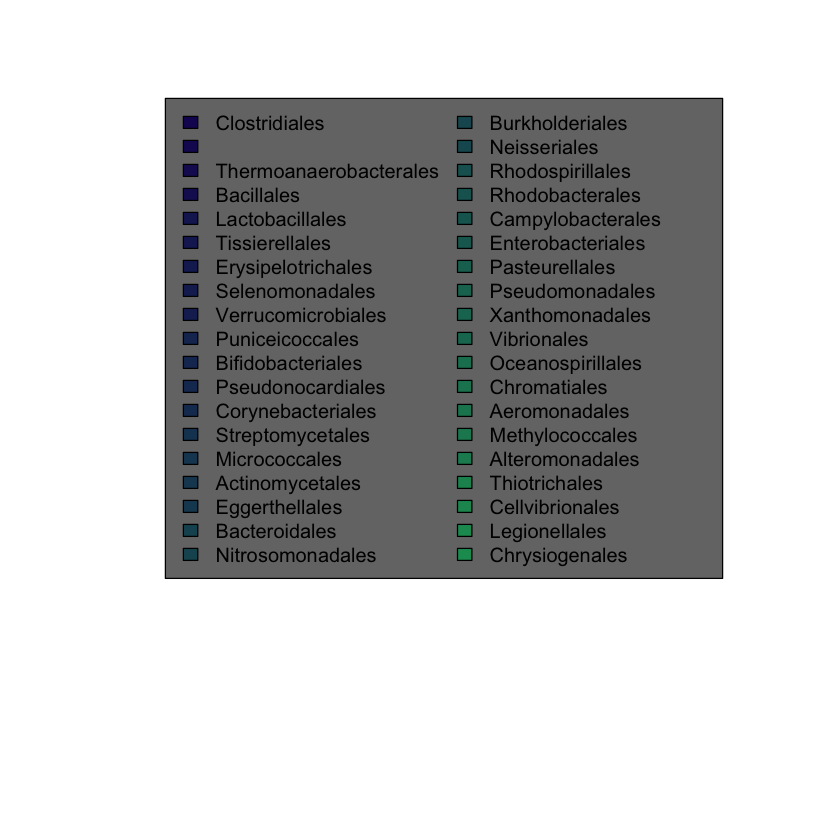

In [134]:
# antGLasso fixed iterative core, zs
plot.graph(
    graph.adjacency(
        antGLasso.path[[12]],
        mode = "Undirected"
    ),
    taxmat_el,
    "Order"
)

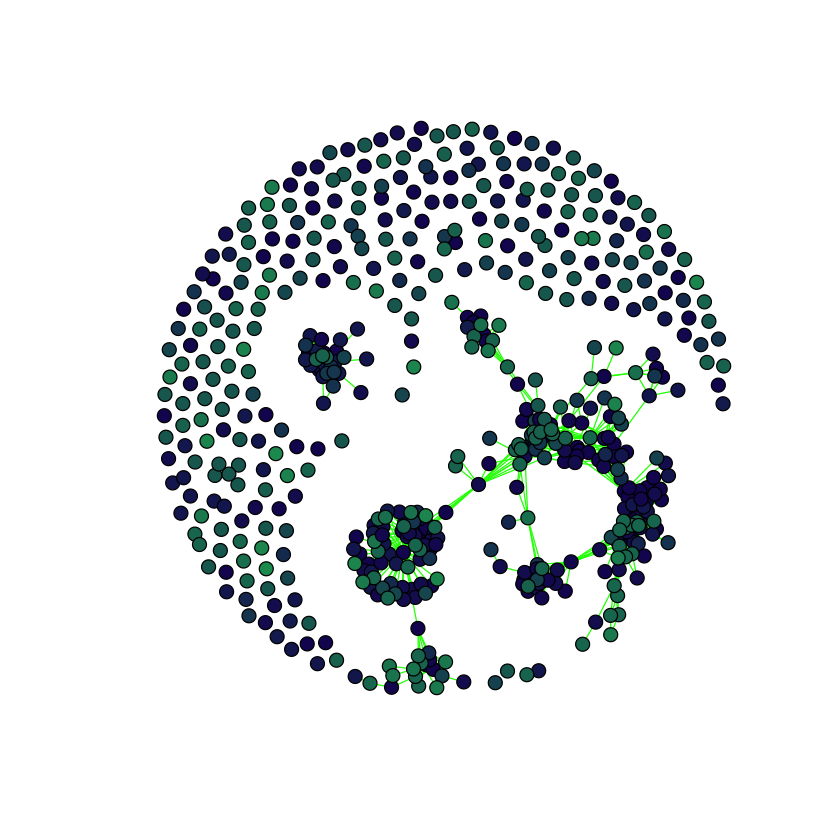

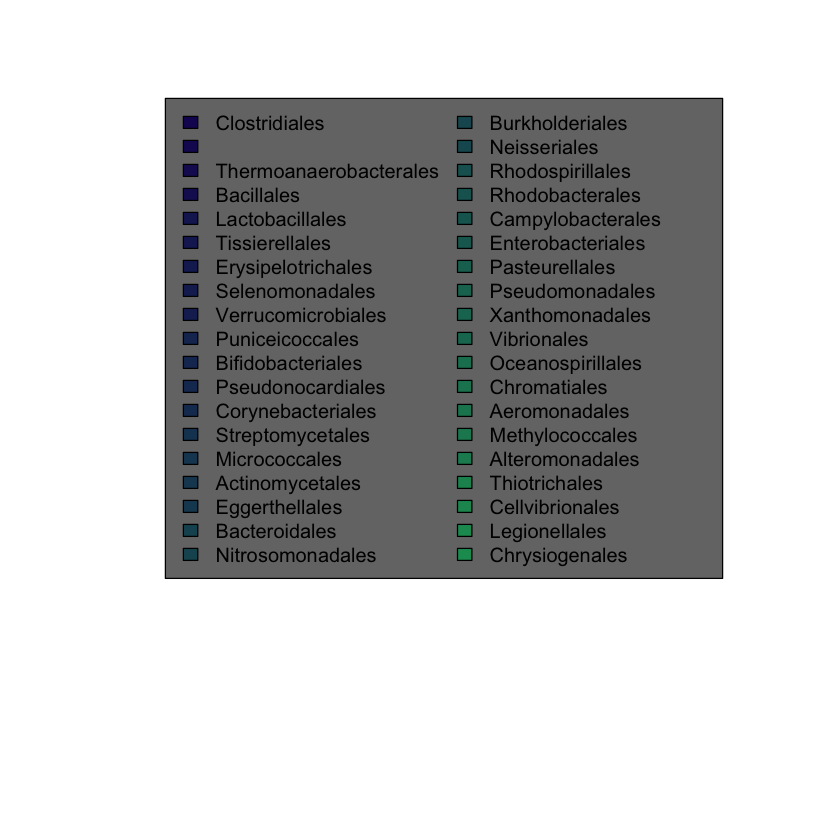

In [255]:
# antGLasso sped-up fixed iterative core, raws
plot.graph(
    graph.adjacency(
        antGLasso.path[[10]],
        mode = "Undirected"
    ),
    taxmat_el,
    "Order"
)

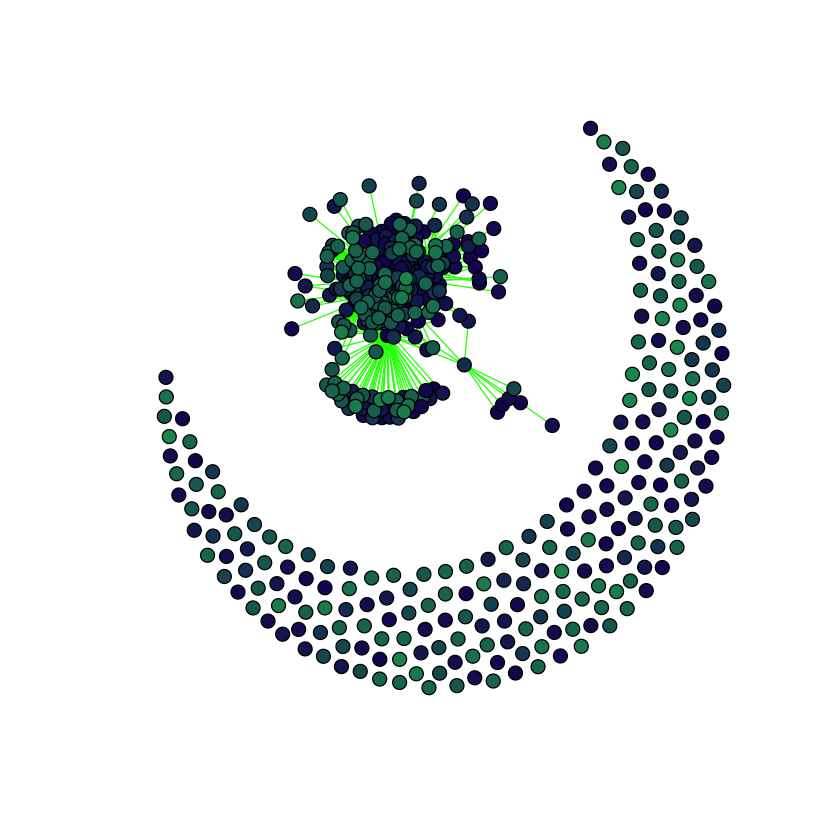

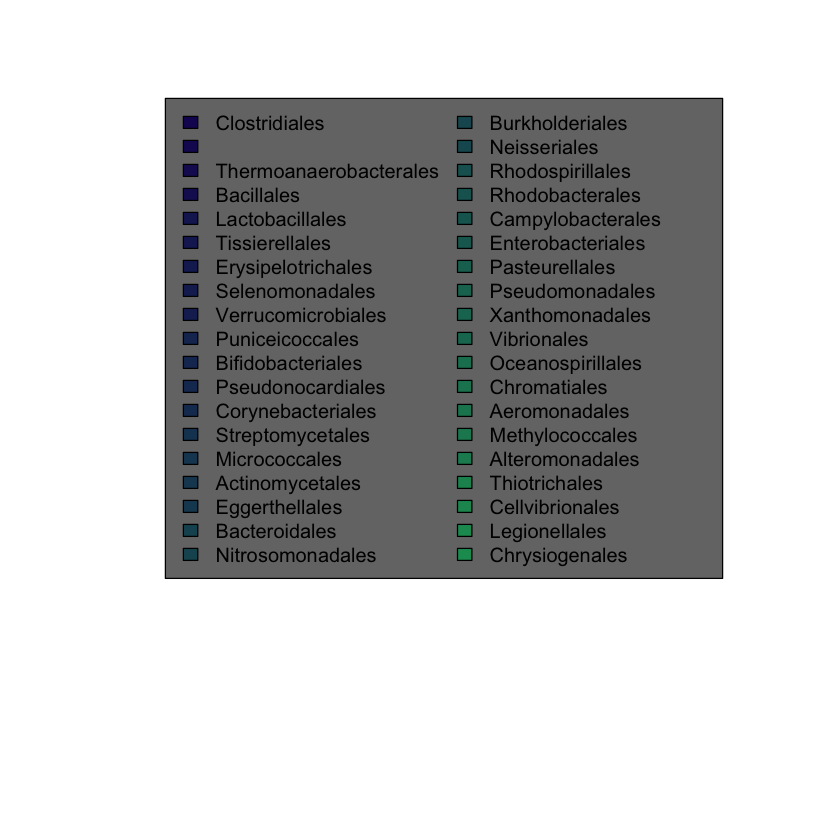

In [239]:
# antGLasso sped-up fixed iterative core, zs
plot.graph(
    graph.adjacency(
        antGLasso.path[[12]],
        mode = "Undirected"
    ),
    taxmat_el,
    "Order"
)